In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Define os nomes das colunas e as larguras de cada campo
colspecs = [(2, 10), (10, 22), (56, 69), (82, 95)]
names = ['Data', 'Codigo', 'Preco_Abertura', 'Preco_Fechamento']

# Carrega os arquivos
df_2022 = pd.read_fwf('COTAHIST_A2022.TXT', colspecs=colspecs, names=names, header=None)
df_2023 = pd.read_fwf('COTAHIST_A2023.TXT', colspecs=colspecs, names=names, header=None)
df_2024 = pd.read_fwf('COTAHIST_A2024.TXT', colspecs=colspecs, names=names, header=None)

# Combine os dataframes de 2022 e 2023 para formar o dataframe de treinamento
frames = [df_2022, df_2023]
df_train = pd.concat(frames)

In [28]:
# Filtra os dados da Amazon
ELETROBRAS_df = df_train[df_train['Codigo'].str.endswith('02ELET3')].copy()

# Converte a coluna 'Data' para o formato de data apropriado
ELETROBRAS_df['Data'] = pd.to_datetime(ELETROBRAS_df['Data'], format='%Y%m%d')
ELETROBRAS_df['Ano'] = ELETROBRAS_df['Data'].dt.year
ELETROBRAS_df['Mes'] = ELETROBRAS_df['Data'].dt.month
ELETROBRAS_df['Dia'] = ELETROBRAS_df['Data'].dt.day


# Configura o índice do dataframe para as datas
ELETROBRAS_df.set_index('Data', inplace=True)
print(ELETROBRAS_df)

             Codigo  Preco_Abertura  Preco_Fechamento   Ano  Mes  Dia
Data                                                                 
2022-01-03  02ELET3          3344.0            3248.0  2022    1    3
2022-01-19  02ELET3          3193.0            3190.0  2022    1   19
2022-02-21  02ELET3          3477.0            3380.0  2022    2   21
2022-02-04  02ELET3          3404.0            3341.0  2022    2    4
2022-01-04  02ELET3          3262.0            3160.0  2022    1    4
...             ...             ...               ...   ...  ...  ...
2023-12-21  02ELET3          4161.0            4107.0  2023   12   21
2023-12-22  02ELET3          4160.0            4129.0  2023   12   22
2023-12-26  02ELET3          4205.0            4192.0  2023   12   26
2023-12-27  02ELET3          4208.0            4192.0  2023   12   27
2023-12-28  02ELET3          4224.0            4222.0  2023   12   28

[498 rows x 6 columns]


In [29]:
ELETROBRAS_df.head(20)

,Codigo,Preco_Abertura,Preco_Fechamento,Ano,Mes,Dia
Data,,,,,,
2022-01-03,02ELET3,3344.0,3248.0,2022,1,3
2022-01-19,02ELET3,3193.0,3190.0,2022,1,19
2022-02-21,02ELET3,3477.0,3380.0,2022,2,21
2022-02-04,02ELET3,3404.0,3341.0,2022,2,4
2022-01-04,02ELET3,3262.0,3160.0,2022,1,4
2022-02-22,02ELET3,3391.0,3366.0,2022,2,22
2022-01-20,02ELET3,3306.0,3290.0,2022,1,20
2022-02-07,02ELET3,3370.0,3307.0,2022,2,7
2022-01-05,02ELET3,3179.0,3133.0,2022,1,5


In [30]:
window = 30  # Tamanho da janela da média móvel
ELETROBRAS_df['Suavizacao'] = ELETROBRAS_df['Preco_Fechamento'].rolling(window=window).mean()

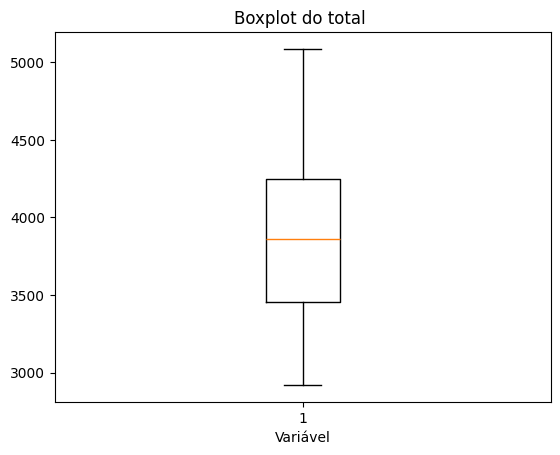

In [31]:
plt.boxplot(ELETROBRAS_df['Preco_Fechamento'])
plt.title('Boxplot do total ')
plt.xlabel('Variável')
plt.show()

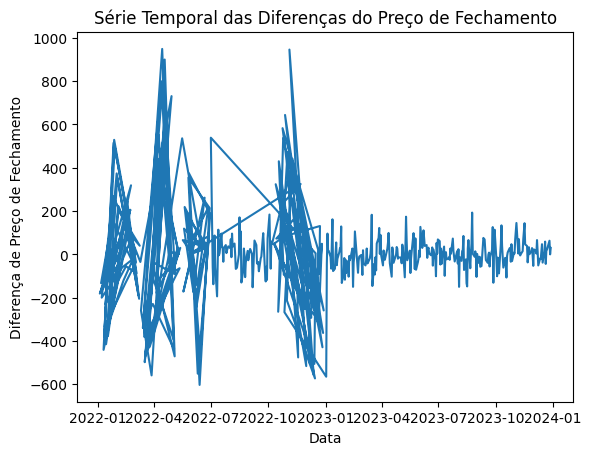

In [32]:
ELETROBRAS_df['Diferenca'] = ELETROBRAS_df['Preco_Fechamento'].diff()
plt.plot(ELETROBRAS_df['Diferenca'])
plt.title('Série Temporal das Diferenças do Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Diferença de Preço de Fechamento')
plt.show()

In [33]:
resultado_teste = adfuller(ELETROBRAS_df['Suavizacao'].dropna())  # Dropna para remover valores nulos da janela da média móvel
print('Estatística do teste:', resultado_teste[0])
print('Valor-p:', resultado_teste[1])


Estatística do teste: -1.9566440533832299
Valor-p: 0.30590053495497793


In [34]:
p, d, q = 1, 1, 1
modelo = ARIMA(ELETROBRAS_df['Suavizacao'].dropna(), order=(p, d, q))  # Dropna para remover valores nulos da janela da média móvel
resultado = modelo.fit()


In [35]:
# Filtra os dados de 2024 para fazer previsões
ELETROBRAS2024_df = df_2024[df_2024['Codigo'].str.endswith('AMZO34')].copy()

# Converte a coluna 'Data' para o formato de data apropriado
ELETROBRAS2024_df['Data'] = pd.to_datetime(ELETROBRAS2024_df['Data'], format='%Y%m%d')


In [36]:
horizonte = 10
previsoes = resultado.predict(start=len(ELETROBRAS_df), end=len(ELETROBRAS_df)+horizonte-1, typ='levels')


KeyError: 'Data'

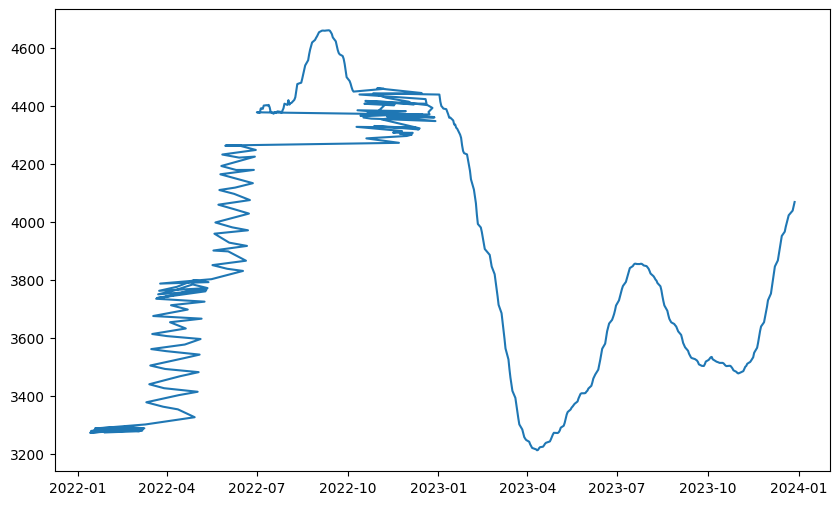

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(ELETROBRAS_df.index, ELETROBRAS_df['Suavizacao'], label='Preço de Fechamento Suavizado (Histórico)')
plt.plot(ELETROBRAS_df['Data'][:horizonte], previsoes, marker='o', linestyle='--', color='red', label='Previsões ARIMA')
plt.title('Previsões ARIMA para o Preço de Fechamento Suavizado da Amazon')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()